In [1]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image

import cv2
import numpy as np
import requests
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
from torchvision import transforms

import torchlens

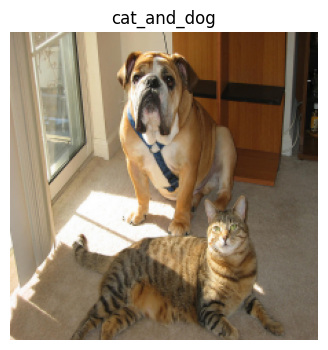

In [2]:
# Load image
cat_and_dog_image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
cat_and_dog = np.array(Image.open(requests.get(cat_and_dog_image_url, stream=True).raw))
# Display the image using matplotlib
plt.figure(figsize=(5, 4))
plt.imshow(cat_and_dog)
plt.axis('off')  # Hide axes
plt.title('cat_and_dog')
plt.show()

In [3]:
# Convert to float32 first for matplotlib compatibility, then convert back to float16 for model
cat_and_dog = np.float32(cat_and_dog) / 255  # Keep float32 for model
input_tensor = preprocess_image(cat_and_dog, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [4]:
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

In [5]:
# Check the model's parameter precision
print(f"Model parameter dtype: {next(model.parameters()).dtype}")
print(f"Input tensor dtype: {input_tensor.dtype}")

Model parameter dtype: torch.float32
Input tensor dtype: torch.float32


In [6]:
torchlens.show_model_graph(model, input_tensor, vis_opt='unrolled', vis_nesting_depth=2, vis_direction='leftright', save_only=True)

In [7]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device: {device}")
model.to(device)
input_tensor = input_tensor.to(device)

Using device: cuda


In [8]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
import os

# 创建保存目录
save_dir = "alexnet_conv_weights"
os.makedirs(save_dir, exist_ok=True)

# 遍历模型的所有卷积层并保存权重
conv_layer_count = 0
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        conv_layer_count += 1
        
        # 获取权重和偏置
        weight = module.weight.detach().cpu()
        bias = module.bias.detach().cpu() if module.bias is not None else None
        
        # 保存权重
        weight_filename = f"conv{conv_layer_count}_weight_{name.replace('.', '_')}.pt"
        torch.save(weight, os.path.join(save_dir, weight_filename))
        
        # 保存偏置（如果存在）
        if bias is not None:
            bias_filename = f"conv{conv_layer_count}_bias_{name.replace('.', '_')}.pt"
            torch.save(bias, os.path.join(save_dir, bias_filename))
        
        # 打印信息
        print(f"Layer: {name}")
        print(f"  Weight shape: {weight.shape}")
        print(f"  Bias shape: {bias.shape if bias is not None else 'None'}")
        print(f"  Saved weight: {weight_filename}")
        if bias is not None:
            print(f"  Saved bias: {bias_filename}")
        print()

print(f"Total {conv_layer_count} convolutional layers saved to '{save_dir}' directory")

Layer: features.0
  Weight shape: torch.Size([64, 3, 11, 11])
  Bias shape: torch.Size([64])
  Saved weight: conv1_weight_features_0.pt
  Saved bias: conv1_bias_features_0.pt

Layer: features.3
  Weight shape: torch.Size([192, 64, 5, 5])
  Bias shape: torch.Size([192])
  Saved weight: conv2_weight_features_3.pt
  Saved bias: conv2_bias_features_3.pt

Layer: features.6
  Weight shape: torch.Size([384, 192, 3, 3])
  Bias shape: torch.Size([384])
  Saved weight: conv3_weight_features_6.pt
  Saved bias: conv3_bias_features_6.pt

Layer: features.8
  Weight shape: torch.Size([256, 384, 3, 3])
  Bias shape: torch.Size([256])
  Saved weight: conv4_weight_features_8.pt
  Saved bias: conv4_bias_features_8.pt

Layer: features.10
  Weight shape: torch.Size([256, 256, 3, 3])
  Bias shape: torch.Size([256])
  Saved weight: conv5_weight_features_10.pt
  Saved bias: conv5_bias_features_10.pt

Total 5 convolutional layers saved to 'alexnet_conv_weights' directory


In [10]:
target_layers = [model.features[0], model.features[3], model.features[6], model.features[8], model.features[10]]

targets = [ClassifierOutputTarget(246)] # 281 is the ImageNet index of 'tabby, tabby cat', 246 is 'boxer'


# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.



# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

print(f"grayscale_cam shape: {grayscale_cam.shape}")
# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
# Use float32 version for visualization to avoid matplotlib issues
visualization = show_cam_on_image(cat_and_dog, grayscale_cam, use_rgb=True)

grayscale_cam shape: (1, 224, 224)


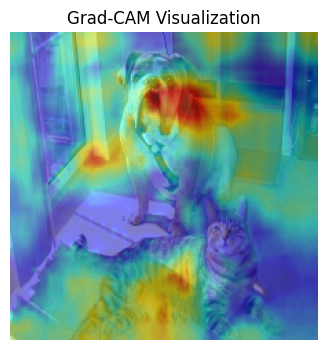

In [11]:
# Display the CAM visualization
plt.figure(figsize=(5, 4))
plt.imshow(visualization)
plt.axis('off')  # Hide axes
plt.title('Grad-CAM Visualization')
plt.show()

In [12]:
len(cam.activations_and_grads.gradients), len(cam.activations_and_grads.activations)

(5, 5)

In [13]:
for grad in cam.activations_and_grads.gradients:
    print(grad.shape)

torch.Size([1, 64, 55, 55])
torch.Size([1, 192, 27, 27])
torch.Size([1, 384, 13, 13])
torch.Size([1, 256, 13, 13])
torch.Size([1, 256, 13, 13])


In [14]:
# 统计每层梯度的稀疏性
print("=== 梯度稀疏性分析 ===")
print(f"总共有 {len(cam.activations_and_grads.gradients)} 层的梯度")
print()

sparsity_stats = []

for i, grad in enumerate(cam.activations_and_grads.gradients):
    # 计算基本统计信息
    total_elements = grad.numel()
    
    # 计算零值数量（考虑浮点数精度，使用较小的阈值）
    zero_threshold = 1e-8
    zero_count = torch.sum(torch.abs(grad) < zero_threshold).item()
    nonzero_count = total_elements - zero_count
    
    # 计算稀疏性比例
    sparsity_ratio = zero_count / total_elements
    
    # 计算其他统计信息
    grad_abs = torch.abs(grad)
    mean_abs = grad_abs.mean().item()
    std_abs = grad_abs.std().item()
    max_abs = grad_abs.max().item()
    min_abs = grad_abs.min().item()
    
    # 计算不同阈值下的稀疏性
    sparsity_1e6 = torch.sum(torch.abs(grad) < 1e-6).item() / total_elements
    sparsity_1e5 = torch.sum(torch.abs(grad) < 1e-5).item() / total_elements
    sparsity_1e4 = torch.sum(torch.abs(grad) < 1e-4).item() / total_elements
    
    stats = {
        'layer': i,
        'shape': grad.shape,
        'total_elements': total_elements,
        'zero_count': zero_count,
        'nonzero_count': nonzero_count,
        'sparsity_ratio': sparsity_ratio,
        'mean_abs': mean_abs,
        'std_abs': std_abs,
        'max_abs': max_abs,
        'min_abs': min_abs,
        'sparsity_1e6': sparsity_1e6,
        'sparsity_1e5': sparsity_1e5,
        'sparsity_1e4': sparsity_1e4
    }
    
    sparsity_stats.append(stats)
    
    print(f"第 {i+1} 层 (形状: {grad.shape}):")
    print(f"  总元素数: {total_elements:,}")
    print(f"  零值数量 (阈值 1e-8): {zero_count:,} ({sparsity_ratio:.4%})")
    print(f"  非零值数量: {nonzero_count:,}")
    print(f"  梯度绝对值统计:")
    print(f"    最小值: {min_abs:.2e}")
    print(f"    最大值: {max_abs:.2e}")
    print(f"    均值: {mean_abs:.2e}")
    print(f"    标准差: {std_abs:.2e}")
    print(f"  不同阈值下的稀疏性:")
    print(f"    < 1e-6: {sparsity_1e6:.4%}")
    print(f"    < 1e-5: {sparsity_1e5:.4%}")
    print(f"    < 1e-4: {sparsity_1e4:.4%}")
    print()

=== 梯度稀疏性分析 ===
总共有 5 层的梯度

第 1 层 (形状: torch.Size([1, 64, 55, 55])):
  总元素数: 193,600
  零值数量 (阈值 1e-8): 168,376 (86.9711%)
  非零值数量: 25,224
  梯度绝对值统计:
    最小值: 0.00e+00
    最大值: 2.10e-01
    均值: 7.26e-04
    标准差: 3.28e-03
  不同阈值下的稀疏性:
    < 1e-6: 86.9726%
    < 1e-5: 86.9902%
    < 1e-4: 87.2020%

第 2 层 (形状: torch.Size([1, 192, 27, 27])):
  总元素数: 139,968
  零值数量 (阈值 1e-8): 128,269 (91.6417%)
  非零值数量: 11,699
  梯度绝对值统计:
    最小值: 0.00e+00
    最大值: 6.86e-02
    均值: 2.45e-04
    标准差: 1.38e-03
  不同阈值下的稀疏性:
    < 1e-6: 91.6438%
    < 1e-5: 91.6688%
    < 1e-4: 91.9574%

第 3 层 (形状: torch.Size([1, 384, 13, 13])):
  总元素数: 64,896
  零值数量 (阈值 1e-8): 54,392 (83.8141%)
  非零值数量: 10,504
  梯度绝对值统计:
    最小值: 0.00e+00
    最大值: 2.98e-02
    均值: 3.04e-04
    标准差: 1.08e-03
  不同阈值下的稀疏性:
    < 1e-6: 83.8233%
    < 1e-5: 83.8650%
    < 1e-4: 84.5692%

第 4 层 (形状: torch.Size([1, 256, 13, 13])):
  总元素数: 43,264
  零值数量 (阈值 1e-8): 34,133 (78.8947%)
  非零值数量: 9,131
  梯度绝对值统计:
    最小值: 0.00e+00
    最大值: 2.25e-02
    均值: 4.

=== 稀疏性可视化分析 ===


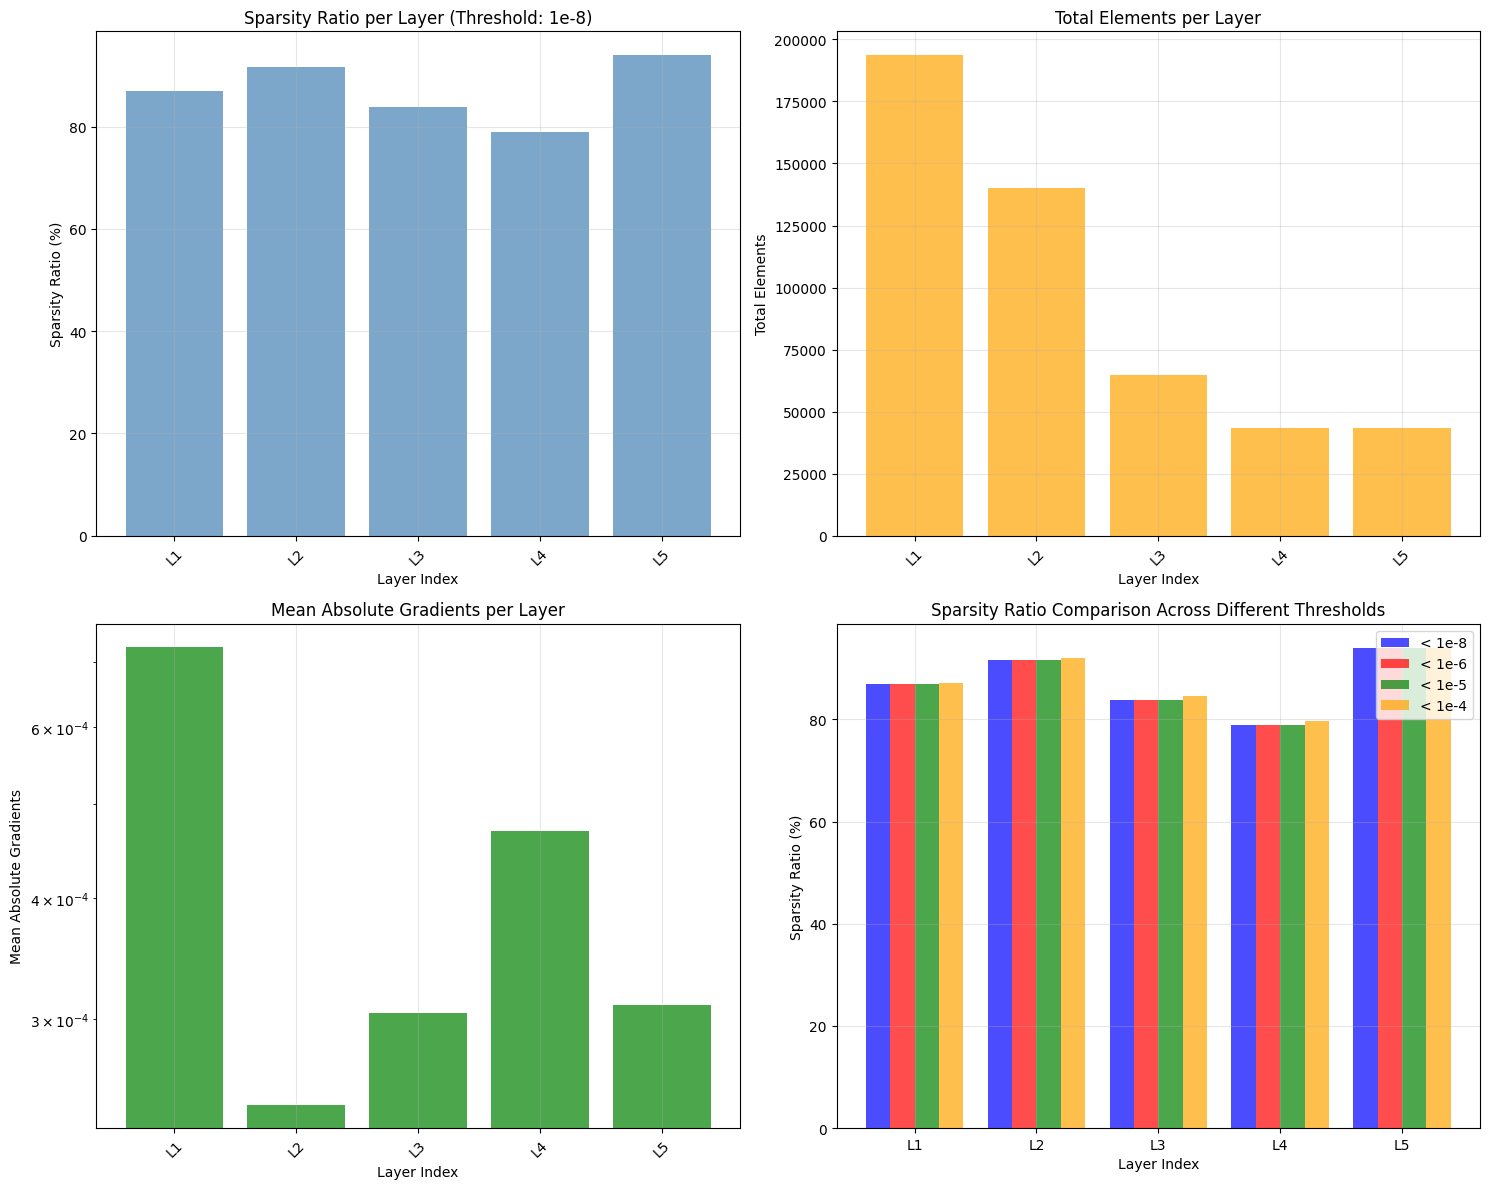

In [15]:
# 可视化稀疏性分析
import matplotlib.pyplot as plt
import numpy as np

print("=== 稀疏性可视化分析 ===")

# 提取数据用于可视化
layer_names = [f"Layer {i+1}\n{stats['shape']}" for i, stats in enumerate(sparsity_stats)]
sparsity_ratios = [stats['sparsity_ratio'] for stats in sparsity_stats]
total_elements = [stats['total_elements'] for stats in sparsity_stats]
mean_abs_grads = [stats['mean_abs'] for stats in sparsity_stats]

# 创建多子图可视化
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 稀疏性比例柱状图
axes[0, 0].bar(range(len(sparsity_ratios)), [s * 100 for s in sparsity_ratios], 
               color='steelblue', alpha=0.7)
axes[0, 0].set_xlabel('Layer Index')
axes[0, 0].set_ylabel('Sparsity Ratio (%)')
axes[0, 0].set_title('Sparsity Ratio per Layer (Threshold: 1e-8)')
axes[0, 0].set_xticks(range(len(layer_names)))
axes[0, 0].set_xticklabels([f"L{i+1}" for i in range(len(layer_names))], rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# 2. 总元素数量
axes[0, 1].bar(range(len(total_elements)), total_elements, color='orange', alpha=0.7)
axes[0, 1].set_xlabel('Layer Index')
axes[0, 1].set_ylabel('Total Elements')
axes[0, 1].set_title('Total Elements per Layer')
axes[0, 1].set_xticks(range(len(layer_names)))
axes[0, 1].set_xticklabels([f"L{i+1}" for i in range(len(layer_names))], rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# 3. 平均绝对梯度值
axes[1, 0].bar(range(len(mean_abs_grads)), mean_abs_grads, color='green', alpha=0.7)
axes[1, 0].set_xlabel('Layer Index')
axes[1, 0].set_ylabel('Mean Absolute Gradients')
axes[1, 0].set_title('Mean Absolute Gradients per Layer')
axes[1, 0].set_xticks(range(len(layer_names)))
axes[1, 0].set_xticklabels([f"L{i+1}" for i in range(len(layer_names))], rotation=45)
axes[1, 0].set_yscale('log')  # 使用对数尺度
axes[1, 0].grid(True, alpha=0.3)

# 4. 不同阈值下的稀疏性比较
thresholds = ['1e-8', '1e-6', '1e-5', '1e-4']
sparsity_data = []
for threshold in ['sparsity_ratio', 'sparsity_1e6', 'sparsity_1e5', 'sparsity_1e4']:
    sparsity_data.append([stats[threshold] * 100 for stats in sparsity_stats])

x = np.arange(len(layer_names))
width = 0.2
colors = ['blue', 'red', 'green', 'orange']

for i, (data, color, threshold) in enumerate(zip(sparsity_data, colors, thresholds)):
    axes[1, 1].bar(x + i * width, data, width, label=f'< {threshold}', 
                   color=color, alpha=0.7)

axes[1, 1].set_xlabel('Layer Index')
axes[1, 1].set_ylabel('Sparsity Ratio (%)')
axes[1, 1].set_title('Sparsity Ratio Comparison Across Different Thresholds')
axes[1, 1].set_xticks(x + width * 1.5)
axes[1, 1].set_xticklabels([f"L{i+1}" for i in range(len(layer_names))])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== 深入梯度分布分析 ===

第 1 层详细分析:
  绝对值分位数分析:
     1%: 0.00e+00
     5%: 0.00e+00
    10%: 0.00e+00
    25%: 0.00e+00
    50%: 0.00e+00
    75%: 0.00e+00
    90%: 1.24e-03
    95%: 4.54e-03
    99%: 1.50e-02
  梯度值分布:
    正值: 12,561 (6.4881%)
    负值: 12,663 (6.5408%)
    精确零值: 168,376 (86.9711%)
  非零梯度统计 (阈值 1e-8):
    数量: 25,224
    均值: 2.80e-05
    标准差: 9.30e-03
    最小值: -2.10e-01
    最大值: 1.09e-01

第 2 层详细分析:
  绝对值分位数分析:
     1%: 0.00e+00
     5%: 0.00e+00
    10%: 0.00e+00
    25%: 0.00e+00
    50%: 0.00e+00
    75%: 0.00e+00
    90%: 0.00e+00
    95%: 1.31e-03
    99%: 6.07e-03
  梯度值分布:
    正值: 6,044 (4.3181%)
    负值: 5,655 (4.0402%)
    精确零值: 128,269 (91.6417%)
  非零梯度统计 (阈值 1e-8):
    数量: 11,699
    均值: 1.18e-04
    标准差: 4.84e-03
    最小值: -6.86e-02
    最大值: 4.86e-02

第 3 层详细分析:
  绝对值分位数分析:
     1%: 0.00e+00
     5%: 0.00e+00
    10%: 0.00e+00
    25%: 0.00e+00
    50%: 0.00e+00
    75%: 0.00e+00
    90%: 9.01e-04
    95%: 2.11e-03
    99%: 5.19e-03
  梯度值分布:
    正值: 5,452 (8.4011%)
    

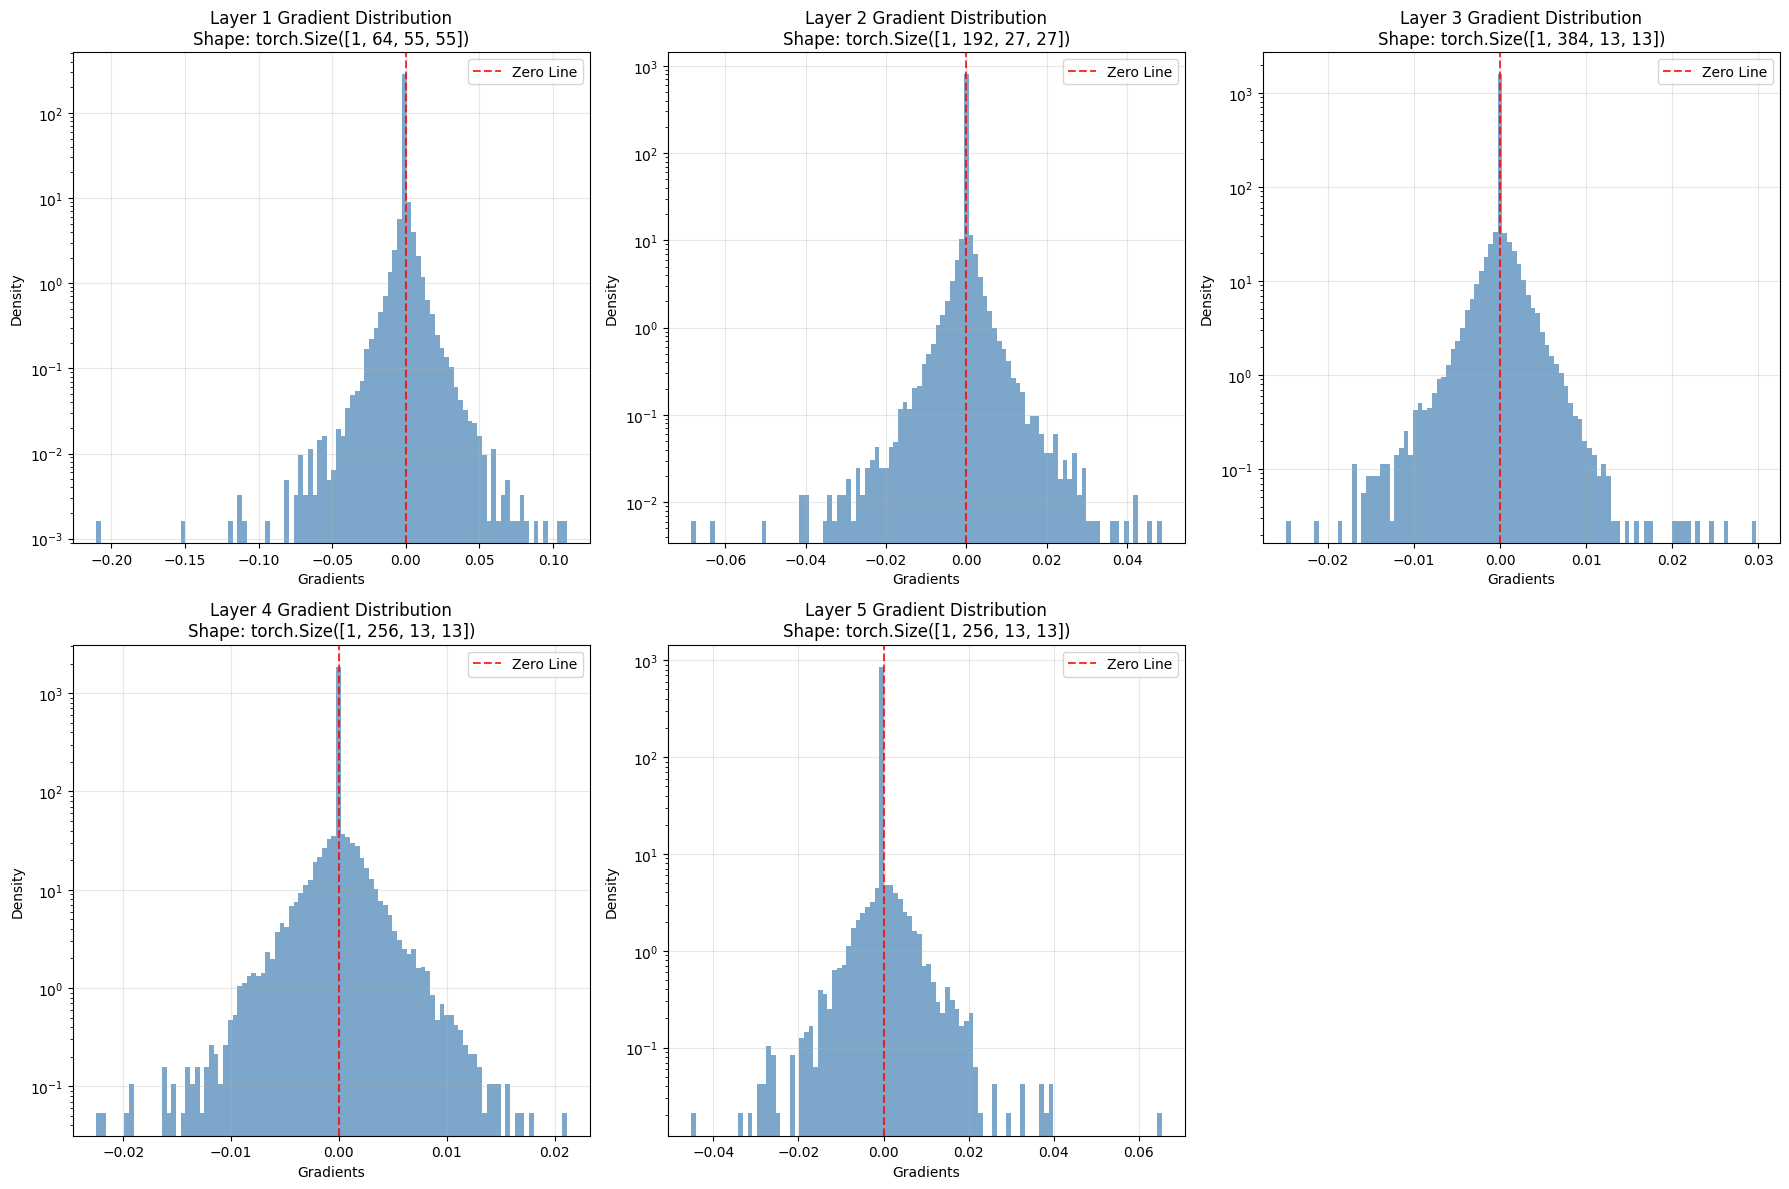

In [16]:
# 深入分析每层梯度的分布特性
print("=== 深入梯度分布分析 ===")

# 分析每层梯度的分布特征
for i, (grad, stats) in enumerate(zip(cam.activations_and_grads.gradients, sparsity_stats)):
    print(f"\n第 {i+1} 层详细分析:")
    
    # 将梯度转换为numpy数组进行分析
    grad_np = grad.detach().cpu().numpy().flatten()
    
    # 计算分位数
    percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
    percentile_values = np.percentile(np.abs(grad_np), percentiles)
    
    print(f"  绝对值分位数分析:")
    for p, v in zip(percentiles, percentile_values):
        print(f"    {p:2d}%: {v:.2e}")
    
    # 分析梯度值的分布
    positive_count = np.sum(grad_np > 0)
    negative_count = np.sum(grad_np < 0)
    zero_count_exact = np.sum(grad_np == 0)
    
    print(f"  梯度值分布:")
    print(f"    正值: {positive_count:,} ({positive_count/len(grad_np):.4%})")
    print(f"    负值: {negative_count:,} ({negative_count/len(grad_np):.4%})")
    print(f"    精确零值: {zero_count_exact:,} ({zero_count_exact/len(grad_np):.4%})")
    
    # 计算有效梯度(非零梯度)的统计信息
    nonzero_mask = np.abs(grad_np) > 1e-8
    if np.any(nonzero_mask):
        nonzero_grads = grad_np[nonzero_mask]
        print(f"  非零梯度统计 (阈值 1e-8):")
        print(f"    数量: {len(nonzero_grads):,}")
        print(f"    均值: {np.mean(nonzero_grads):.2e}")
        print(f"    标准差: {np.std(nonzero_grads):.2e}")
        print(f"    最小值: {np.min(nonzero_grads):.2e}")
        print(f"    最大值: {np.max(nonzero_grads):.2e}")

# 创建梯度分布的直方图
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (grad, stats) in enumerate(zip(cam.activations_and_grads.gradients, sparsity_stats)):
    if i >= len(axes):
        break
        
    grad_np = grad.detach().cpu().numpy().flatten()
    
    # 绘制梯度分布直方图（对数尺度）
    axes[i].hist(grad_np, bins=100, alpha=0.7, color='steelblue', density=True)
    axes[i].set_xlabel('Gradients')
    axes[i].set_ylabel('Density')
    axes[i].set_title(f'Layer {i+1} Gradient Distribution\nShape: {grad.shape}')
    axes[i].set_yscale('log')
    axes[i].grid(True, alpha=0.3)
    
    # 添加零值线
    axes[i].axvline(x=0, color='red', linestyle='--', alpha=0.8, label='Zero Line')
    axes[i].legend()

# 隐藏多余的子图
for i in range(len(cam.activations_and_grads.gradients), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [17]:
# 稀疏性评估和总结
print("=== 稀疏性评估总结 ===")

# 计算总体统计
total_params = sum(stats['total_elements'] for stats in sparsity_stats)
total_zeros = sum(stats['zero_count'] for stats in sparsity_stats)
overall_sparsity = total_zeros / total_params

print(f"整体统计:")
print(f"  所有层总参数数量: {total_params:,}")
print(f"  所有层总零值数量: {total_zeros:,}")
print(f"  整体稀疏性: {overall_sparsity:.4%}")
print()

# 按层分析稀疏性特征
print("稀疏性分析:")
sparsity_levels = []
for i, stats in enumerate(sparsity_stats):
    sparsity = stats['sparsity_ratio']
    if sparsity > 0.5:
        level = "高稀疏"
    elif sparsity > 0.1:
        level = "中等稀疏"
    elif sparsity > 0.01:
        level = "低稀疏"
    else:
        level = "密集"
    
    sparsity_levels.append(level)
    print(f"  第 {i+1} 层: {level} ({sparsity:.4%})")

# 统计不同稀疏性级别的层数
from collections import Counter
level_counts = Counter(sparsity_levels)
print(f"\n稀疏性级别分布:")
for level, count in level_counts.items():
    print(f"  {level}: {count} 层")

# 计算稀疏性的统计指标
sparsity_values = [stats['sparsity_ratio'] for stats in sparsity_stats]
print(f"\n稀疏性统计指标:")
print(f"  最小稀疏性: {np.min(sparsity_values):.4%}")
print(f"  最大稀疏性: {np.max(sparsity_values):.4%}")
print(f"  平均稀疏性: {np.mean(sparsity_values):.4%}")
print(f"  稀疏性标准差: {np.std(sparsity_values):.4%}")

# 分析梯度强度与稀疏性的关系
mean_grads = [stats['mean_abs'] for stats in sparsity_stats]
print(f"\n梯度强度分析:")
print(f"  最强梯度层: 第 {np.argmax(mean_grads) + 1} 层 ({np.max(mean_grads):.2e})")
print(f"  最弱梯度层: 第 {np.argmin(mean_grads) + 1} 层 ({np.min(mean_grads):.2e})")

# 创建相关性分析
correlation = np.corrcoef(sparsity_values, mean_grads)[0, 1]
print(f"  稀疏性与梯度强度相关性: {correlation:.4f}")

# 最终评估
print(f"\n=== 稀疏性评估结论 ===")
if overall_sparsity > 0.5:
    conclusion = "高度稀疏"
    interpretation = "大部分梯度值接近零，可能存在梯度消失问题或网络冗余"
elif overall_sparsity > 0.1:
    conclusion = "中等稀疏"
    interpretation = "部分梯度值较小，网络训练相对正常"
elif overall_sparsity > 0.01:
    conclusion = "低稀疏"
    interpretation = "梯度分布相对均匀，网络训练活跃"
else:
    conclusion = "密集"
    interpretation = "几乎所有梯度都有意义的非零值，网络高度活跃"

print(f"整体评估: {conclusion}")
print(f"解释: {interpretation}")

if len(set(sparsity_levels)) > 2:
    print("注意: 不同层的稀疏性差异较大，建议进一步分析各层的贡献")

if correlation < -0.5:
    print("发现: 稀疏性与梯度强度呈强负相关，符合预期")
elif correlation > 0.5:
    print("异常: 稀疏性与梯度强度呈强正相关，需要进一步调查")

=== 稀疏性评估总结 ===
整体统计:
  所有层总参数数量: 484,992
  所有层总零值数量: 425,805
  整体稀疏性: 87.7963%

稀疏性分析:
  第 1 层: 高稀疏 (86.9711%)
  第 2 层: 高稀疏 (91.6417%)
  第 3 层: 高稀疏 (83.8141%)
  第 4 层: 高稀疏 (78.8947%)
  第 5 层: 高稀疏 (93.9234%)

稀疏性级别分布:
  高稀疏: 5 层

稀疏性统计指标:
  最小稀疏性: 78.8947%
  最大稀疏性: 93.9234%
  平均稀疏性: 87.0490%
  稀疏性标准差: 5.3910%

梯度强度分析:
  最强梯度层: 第 1 层 (7.26e-04)
  最弱梯度层: 第 2 层 (2.45e-04)
  稀疏性与梯度强度相关性: -0.3413

=== 稀疏性评估结论 ===
整体评估: 高度稀疏
解释: 大部分梯度值接近零，可能存在梯度消失问题或网络冗余


In [18]:
for i, grad in enumerate(cam.activations_and_grads.gradients):
    # 计算基本统计信息
    total_elements = grad.numel()
    
    # 计算零值数量（考虑浮点数精度，使用较小的阈值）
    zero_count = torch.sum(torch.abs(grad) == 0.0).item()
    nonzero_count = total_elements - zero_count
    
    # 计算稀疏性比例
    sparsity_ratio = zero_count / total_elements

    print(f'Layer {i+1}: Total Elements={total_elements}, Zero Count={zero_count}, Sparsity Ratio={sparsity_ratio:.4%}')

Layer 1: Total Elements=193600, Zero Count=168376, Sparsity Ratio=86.9711%
Layer 2: Total Elements=139968, Zero Count=128269, Sparsity Ratio=91.6417%
Layer 3: Total Elements=64896, Zero Count=54392, Sparsity Ratio=83.8141%
Layer 4: Total Elements=43264, Zero Count=34133, Sparsity Ratio=78.8947%
Layer 5: Total Elements=43264, Zero Count=40635, Sparsity Ratio=93.9234%


In [19]:
# 创建保存梯度的目录
gradient_dir = "alexnet_gradients"
os.makedirs(gradient_dir, exist_ok=True)

# 保存每层的梯度
print(f"正在保存 {len(cam.activations_and_grads.gradients)} 层的梯度...")

for i, grad in enumerate(cam.activations_and_grads.gradients):
    # 生成文件名
    gradient_filename = f"layer{i+1}_gradients.pt"
    
    # 保存梯度到文件
    torch.save(grad.detach().cpu(), os.path.join(gradient_dir, gradient_filename))
    
    # 打印保存信息
    print(f"第 {i+1} 层梯度已保存:")
    print(f"  形状: {grad.shape}")
    print(f"  文件名: {gradient_filename}")
    print(f"  数据类型: {grad.dtype}")
    print(f"  设备: {grad.device}")
    print()

print(f"所有梯度已保存到 '{gradient_dir}' 目录")

正在保存 5 层的梯度...
第 1 层梯度已保存:
  形状: torch.Size([1, 64, 55, 55])
  文件名: layer1_gradients.pt
  数据类型: torch.float32
  设备: cpu

第 2 层梯度已保存:
  形状: torch.Size([1, 192, 27, 27])
  文件名: layer2_gradients.pt
  数据类型: torch.float32
  设备: cpu

第 3 层梯度已保存:
  形状: torch.Size([1, 384, 13, 13])
  文件名: layer3_gradients.pt
  数据类型: torch.float32
  设备: cpu

第 4 层梯度已保存:
  形状: torch.Size([1, 256, 13, 13])
  文件名: layer4_gradients.pt
  数据类型: torch.float32
  设备: cpu

第 5 层梯度已保存:
  形状: torch.Size([1, 256, 13, 13])
  文件名: layer5_gradients.pt
  数据类型: torch.float32
  设备: cpu

所有梯度已保存到 'alexnet_gradients' 目录
